In [6]:
from SDP_interaction_inference import simulation
from SDP_interaction_inference.constraints import Constraint
from SDP_interaction_inference import optimization
from SDP_interaction_inference import correlation
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [2]:
rng = np.random.default_rng(7)

# Model free dependence test: SDP package

Validate results from 'model_free.ipynb' on the effects of moment order $d$ and moment matrices (SDP) using the SDP package: checking the results hold and the package is working well.

In [3]:
# settings
interaction_values = [10.0, 5.0, 2.0, 1.5, 1.0, 0.75, 0.5, 0.25, 0.1, 0.0]
d_values = range(2, 11)
b = 1
runs = 3
rate = 1
n = 1000

# constraints
constraints_MM = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    factorization=True
)
constraints_NO = Constraint(
    moment_bounds=True,
    moment_matrices=False,
    factorization=True
)

# sample beta
if b == 0:
    beta = np.ones(n)
else:
    beta = rng.beta(1, b, size=n)

# result arrays
results_MM = np.zeros((runs, len(d_values)))
times_MM = np.zeros((runs, len(d_values), len(interaction_values)))
results_NO = np.zeros((runs, len(d_values)))
times_NO = np.zeros((runs, len(d_values), len(interaction_values)))

# for each run
for i in tqdm.tqdm(range(runs)):

    # simulate dataset with range of interaction
    data = simulation.simulate_dataset_range_BD(interaction_values, cells=n, rate=rate)

    # downsample
    data = data.downsample(beta)

    # bootstrap (up to highest order used)
    data.bootstrap(d_values[-1])

    # for each d
    for j, d in enumerate(d_values):

        # test feasibility (with moment matrices)
        opt_MM = optimization.ModelFreeOptimization(data, d, constraints=constraints_MM, printing=False)
        opt_MM.analyse_dataset()

        # test feasibility (without moment matrices)
        opt_NO = optimization.ModelFreeOptimization(data, d, constraints=constraints_NO, printing=False)
        opt_NO.analyse_dataset()

        # record time & smallest interaction strength detected
        results_MM[i, j] = np.inf
        for k, solution in opt_MM.result_dict.items():
            times_MM[i, j, k] = solution['time']
            if solution['status'] == "INFEASIBLE":
                k_reg = interaction_values[k]
                prev = results_MM[i, j]
                if k_reg < prev:
                    results_MM[i, j] = k_reg

        results_NO[i, j] = np.inf
        for k, solution in opt_NO.result_dict.items():
            times_NO[i, j, k] = solution['time']
            if solution['status'] == "INFEASIBLE":
                k_reg = interaction_values[k]
                prev = results_NO[i, j]
                if k_reg < prev:
                    results_NO[i, j] = k_reg

100%|██████████| 3/3 [02:39<00:00, 53.14s/it]


In [8]:
# correlation test
corr = correlation.Correlation(data, printing=False)

# smallest interaction strength detected
result_corr = np.inf
for k, solution in corr.result_dict.items():
    k_reg = interaction_values[k]
    p = solution['pvalue']
    if p < 0.05 and k_reg < result_corr:
        result_corr = k_reg

100%|██████████| 10/10 [00:00<00:00, 335.79it/s]


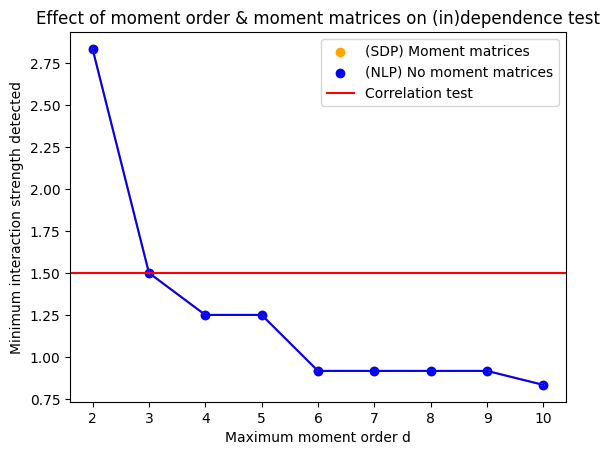

In [9]:
# plot results
plt.plot(d_values, results_MM.mean(axis=0), color="orange")
plt.scatter(d_values, results_MM.mean(axis=0), label="(SDP) Moment matrices", color="orange")
plt.plot(d_values, results_NO.mean(axis=0), color="blue")
plt.scatter(d_values, results_NO.mean(axis=0), label="(NLP) No moment matrices", color="blue")
plt.axhline(result_corr, color="red", label="Correlation test")
plt.xlabel("Maximum moment order d")
plt.ylabel("Minimum interaction strength detected")
plt.title("Effect of moment order & moment matrices on (in)dependence test")
plt.legend()

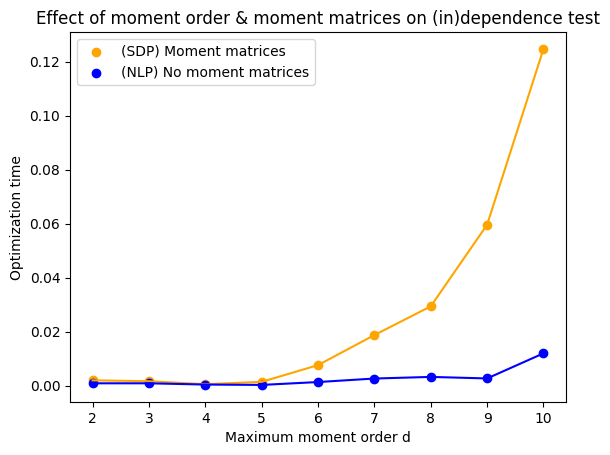

In [ ]:
# plot time
plt.plot(d_values, times_MM.mean(axis=(0, 2)), color="orange")
plt.scatter(d_values, times_MM.mean(axis=(0, 2)), label="(SDP) Moment matrices", color="orange")
plt.plot(d_values, times_NO.mean(axis=(0, 2)), color="blue")
plt.scatter(d_values, times_NO.mean(axis=(0, 2)), label="(NLP) No moment matrices", color="blue")
plt.xlabel("Maximum moment order d")
plt.ylabel("Optimization time")
plt.title("Effect of moment order & moment matrices on (in)dependence test")
plt.legend()

## Results

Moment matrices have no effect on minimum interaction strength detected and only slow down optimization more as $d$ increases.

By removing them we avoid solving an SDP, instead only needing to solve an NLP. There is likely no effect because the bootstrapped moment intervals should (almost) always be valid sets of moments (modulo sampling error) and with no unobserved species the semidefinite constraints will not be violated.

Increasing $d$ lowers the minimum interaction strength that can be detected, but with diminishing returns.

Correlation test gives the same result as $d = 3$, remains to be seen if this is consistently true.

There are issues when using large values of $d$ e.g. $d > 10$: the bootstrap bounds widen and provide less information (diminishing returns), and large moment orders mean large powers and large values which can overflow into negatives (false positives). See below for some investigation into large $d$ results:

### False positive example: d = 30

In [72]:
# settings
interaction_values = [10.0, 5.0, 2.0, 1.5, 1.0, 0.75, 0.5, 0.25, 0.1, 0.0]
d = 30
b = 0.5
runs = 3
rate = 1
n = 1000

# constraints
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=False,
    factorization=True
)

# sample beta
if b == 0:
    beta = np.ones(n)
else:
    beta = rng.beta(1, b, size=n)

# simulate dataset with range of interaction
data = simulation.simulate_dataset_range_BD(interaction_values, cells=n, rate=rate, tqdm_disable=False)

# downsample
data = data.downsample(beta)

# bootstrap (up to highest order used)
data.bootstrap(d)

# test feasibility (without moment matrices)
opt = optimization.ModelFreeOptimization(data, d, constraints=constraints, printing=False)
opt.analyse_dataset()

# display
for k, solution in opt.result_dict.items():
    k_reg = interaction_values[k]
    print(f"k_reg = {k_reg} is {solution['status']} in {solution['time']}")

100%|██████████| 10/10 [15:22<00:00, 92.26s/it]

k_reg = 10.0 is INFEASIBLE in 0.002000093460083008
k_reg = 5.0 is INFEASIBLE in 0.002000093460083008
k_reg = 2.0 is INFEASIBLE in 0.0010001659393310547
k_reg = 1.5 is INFEASIBLE in 0.0019998550415039062
k_reg = 1.0 is INFEASIBLE in 0.009000062942504883
k_reg = 0.75 is INFEASIBLE in 0.006999969482421875
k_reg = 0.5 is INFEASIBLE in 0.042999982833862305
k_reg = 0.25 is INFEASIBLE in 0.009000062942504883
k_reg = 0.1 is INFEASIBLE in 57.83299994468689
k_reg = 0.0 is INFEASIBLE in 2.13700008392334


# Low capture

In [18]:
# settings
interaction_values = [10.0, 5.0, 2.0, 1.5, 1.0, 0.75, 0.5, 0.25, 0.1, 0.0]
d_values = range(2, 11)
m = 0.1
b = (1 / m) - 1
runs = 3
rate = 1
n = 1000

# constraints
constraints_MM = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    factorization=True
)
constraints_NO = Constraint(
    moment_bounds=True,
    moment_matrices=False,
    factorization=True
)

# sample beta
if b == 0:
    beta = np.ones(n)
else:
    beta = rng.beta(1, b, size=n)

# result arrays
results_MM = np.zeros((runs, len(d_values)))
times_MM = np.zeros((runs, len(d_values), len(interaction_values)))
results_NO = np.zeros((runs, len(d_values)))
times_NO = np.zeros((runs, len(d_values), len(interaction_values)))

# for each run
for i in tqdm.tqdm(range(runs)):

    # simulate dataset with range of interaction
    data = simulation.simulate_dataset_range_BD(interaction_values, cells=n, rate=rate)

    # downsample
    data = data.downsample(beta)

    # bootstrap (up to highest order used)
    data.bootstrap(d_values[-1])

    # for each d
    for j, d in enumerate(d_values):

        # test feasibility (with moment matrices)
        opt_MM = optimization.ModelFreeOptimization(data, d, constraints=constraints_MM, printing=False)
        opt_MM.analyse_dataset()

        # test feasibility (without moment matrices)
        opt_NO = optimization.ModelFreeOptimization(data, d, constraints=constraints_NO, printing=False)
        opt_NO.analyse_dataset()

        # record time & smallest interaction strength detected
        results_MM[i, j] = np.inf
        for k, solution in opt_MM.result_dict.items():
            times_MM[i, j, k] = solution['time']
            if solution['status'] == "INFEASIBLE":
                k_reg = interaction_values[k]
                prev = results_MM[i, j]
                if k_reg < prev:
                    results_MM[i, j] = k_reg

        results_NO[i, j] = np.inf
        for k, solution in opt_NO.result_dict.items():
            times_NO[i, j, k] = solution['time']
            if solution['status'] == "INFEASIBLE":
                k_reg = interaction_values[k]
                prev = results_NO[i, j]
                if k_reg < prev:
                    results_NO[i, j] = k_reg

100%|██████████| 3/3 [10:17<00:00, 205.93s/it]


In [19]:
# correlation test
corr = correlation.Correlation(data, printing=False)

# smallest interaction strength detected
result_corr = np.inf
for k, solution in corr.result_dict.items():
    k_reg = interaction_values[k]
    p = solution['pvalue']
    if p < 0.05 and k_reg < result_corr:
        result_corr = k_reg

100%|██████████| 10/10 [00:00<00:00, 259.64it/s]


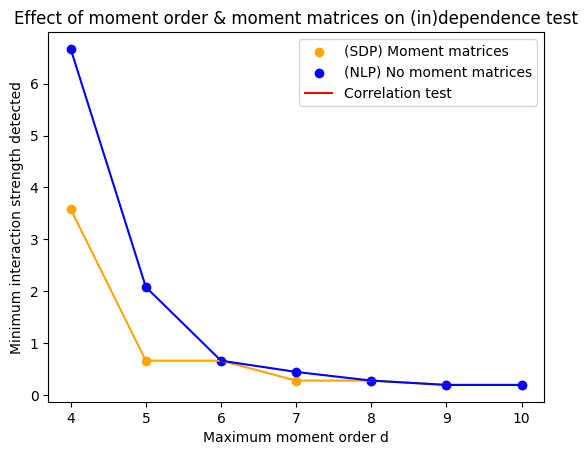

In [22]:
# plot results
plt.plot(d_values, results_MM.mean(axis=0), color="orange")
plt.scatter(d_values, results_MM.mean(axis=0), label="(SDP) Moment matrices", color="orange")
plt.plot(d_values, results_NO.mean(axis=0), color="blue")
plt.scatter(d_values, results_NO.mean(axis=0), label="(NLP) No moment matrices", color="blue")
plt.axhline(result_corr, color="red", label="Correlation test")
plt.xlabel("Maximum moment order d")
plt.ylabel("Minimum interaction strength detected")
plt.title("Effect of moment order & moment matrices on (in)dependence test")
plt.legend()

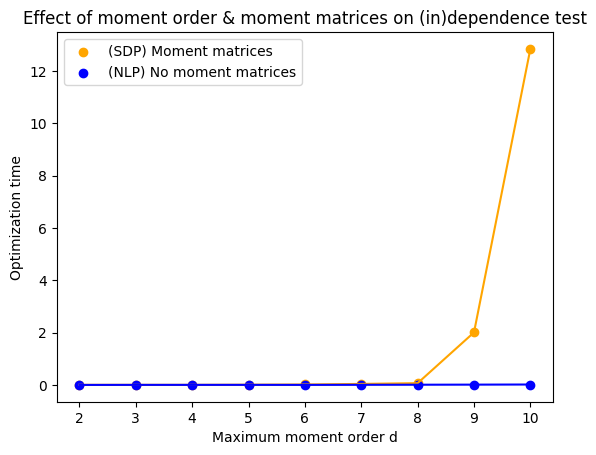

In [23]:
# plot time
plt.plot(d_values, times_MM.mean(axis=(0, 2)), color="orange")
plt.scatter(d_values, times_MM.mean(axis=(0, 2)), label="(SDP) Moment matrices", color="orange")
plt.plot(d_values, times_NO.mean(axis=(0, 2)), color="blue")
plt.scatter(d_values, times_NO.mean(axis=(0, 2)), label="(NLP) No moment matrices", color="blue")
plt.xlabel("Maximum moment order d")
plt.ylabel("Optimization time")
plt.title("Effect of moment order & moment matrices on (in)dependence test")
plt.legend()

## Results

SDP does produce slightly better results for smaller $d$, but the difference largely dissapears by $d \approx 6$.

Perhaps this is because at such low capture efficiency the estimated bounds are wide enough for some moment sets $y$ to not be valid (not satisfy SDP constraints) which are then feasible under NLP, but can be removed and so give an infeasible results under SDP.

Overall a choice of whether to use SDP: for moderate values of $d$ slightly improve results at a cost of slightly slower optimization.

Note: correlation test here does not detect even the highest interaction strength ($k_{reg} = 10$ at $\bar{\beta} = 0.1$)

# No capture

In [28]:
# settings
interaction_values = [10.0, 5.0, 2.0, 1.5, 1.0, 0.75, 0.5, 0.25, 0.1, 0.0]
d_values = range(2, 11)
b = 0
runs = 3
rate = 1
n = 1000

# constraints
constraints_MM = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    factorization=True
)
constraints_NO = Constraint(
    moment_bounds=True,
    moment_matrices=False,
    factorization=True
)

# sample beta
if b == 0:
    beta = np.ones(n)
else:
    beta = rng.beta(1, b, size=n)

# result arrays
results_MM = np.zeros((runs, len(d_values)))
times_MM = np.zeros((runs, len(d_values), len(interaction_values)))
results_NO = np.zeros((runs, len(d_values)))
times_NO = np.zeros((runs, len(d_values), len(interaction_values)))

# for each run
for i in tqdm.tqdm(range(runs)):

    # simulate dataset with range of interaction
    data = simulation.simulate_dataset_range_BD(interaction_values, cells=n, rate=rate)

    # downsample
    data = data.downsample(beta)

    # bootstrap (up to highest order used)
    data.bootstrap(d_values[-1])

    # for each d
    for j, d in enumerate(d_values):

        # test feasibility (with moment matrices)
        opt_MM = optimization.ModelFreeOptimization(data, d, constraints=constraints_MM, printing=False)
        opt_MM.analyse_dataset()

        # test feasibility (without moment matrices)
        opt_NO = optimization.ModelFreeOptimization(data, d, constraints=constraints_NO, printing=False)
        opt_NO.analyse_dataset()

        # record time & smallest interaction strength detected
        results_MM[i, j] = np.inf
        for k, solution in opt_MM.result_dict.items():
            times_MM[i, j, k] = solution['time']
            if solution['status'] == "INFEASIBLE":
                k_reg = interaction_values[k]
                prev = results_MM[i, j]
                if k_reg < prev:
                    results_MM[i, j] = k_reg

        results_NO[i, j] = np.inf
        for k, solution in opt_NO.result_dict.items():
            times_NO[i, j, k] = solution['time']
            if solution['status'] == "INFEASIBLE":
                k_reg = interaction_values[k]
                prev = results_NO[i, j]
                if k_reg < prev:
                    results_NO[i, j] = k_reg

100%|██████████| 3/3 [06:34<00:00, 131.64s/it]


In [32]:
# correlation test
corr = correlation.Correlation(data, printing=False)

# smallest interaction strength detected
result_corr = np.inf
for k, solution in corr.result_dict.items():
    k_reg = interaction_values[k]
    p = solution['pvalue']
    if p < 0.05 and k_reg < result_corr:
        result_corr = k_reg

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 280.63it/s]


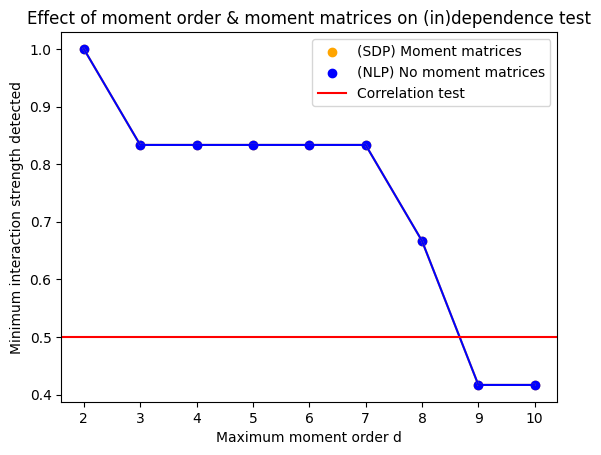

In [33]:
# plot results
plt.plot(d_values, results_MM.mean(axis=0), color="orange")
plt.scatter(d_values, results_MM.mean(axis=0), label="(SDP) Moment matrices", color="orange")
plt.plot(d_values, results_NO.mean(axis=0), color="blue")
plt.scatter(d_values, results_NO.mean(axis=0), label="(NLP) No moment matrices", color="blue")
plt.axhline(result_corr, color="red", label="Correlation test")
plt.xlabel("Maximum moment order d")
plt.ylabel("Minimum interaction strength detected")
plt.title("Effect of moment order & moment matrices on (in)dependence test")
plt.legend()

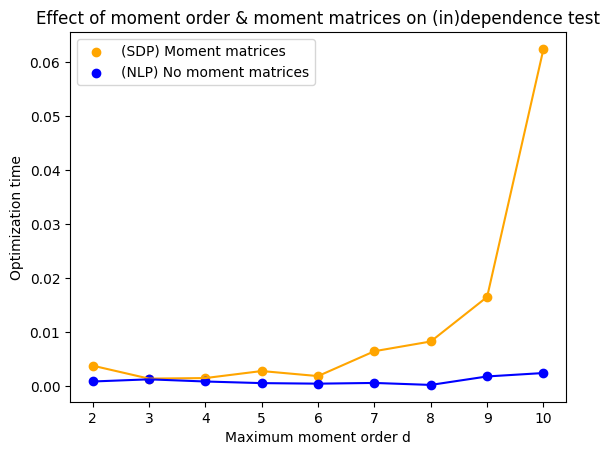

In [34]:
# plot time
plt.plot(d_values, times_MM.mean(axis=(0, 2)), color="orange")
plt.scatter(d_values, times_MM.mean(axis=(0, 2)), label="(SDP) Moment matrices", color="orange")
plt.plot(d_values, times_NO.mean(axis=(0, 2)), color="blue")
plt.scatter(d_values, times_NO.mean(axis=(0, 2)), label="(NLP) No moment matrices", color="blue")
plt.xlabel("Maximum moment order d")
plt.ylabel("Optimization time")
plt.title("Effect of moment order & moment matrices on (in)dependence test")
plt.legend()

## Results



# Gridtests

In [11]:
import time
from matplotlib.colors import LinearSegmentedColormap

In [25]:
def plot(result_array, title, interaction_values, capture_values, figsize=(6, 6), label="Infeasibility (%)"):

    fig, axs = plt.subplots(figsize=figsize)

    #fig.suptitle("Infeasibility %")

    #plt.tight_layout()

    cmap = LinearSegmentedColormap.from_list('br', ["b", "w", "r"], N=256)

    vmin, vmax = 0, 1

    img = axs.imshow(result_array, cmap=cmap, vmin=vmin, vmax=vmax)
    axs.set_xlabel("Mean capture efficiency (Beta dist.)")
    axs.set_xticks(range(len(capture_values)))
    axs.set_xticklabels(capture_values)
    axs.set_ylabel("Interaction strength")
    axs.set_yticks(range(len(interaction_values)))
    axs.set_yticklabels(interaction_values)
    axs.set_title(title)

    cbar = plt.colorbar(img, ax=axs)
    cbar.set_label(label)

## NLP

In [ ]:
# settings
interaction_values = [10.0, 5.0, 2.0, 1.5, 1.0, 0.75, 0.5, 0.25, 0.1, 0.0]
capture_values = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
runs = 3
rate = 1
n = 1000

# result arrays
shape = (len(interaction_values), len(capture_values))
result_2 = np.zeros(shape)
result_3 = np.zeros(shape)
result_5 = np.zeros(shape)
result_10 = np.zeros(shape)
result_corr = np.zeros(shape)

# constraints
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=False,
    factorization=True
)

# count
c = 0
total = runs * len(capture_values)

# running
for i in range(runs):
    
    # simulate interaction range
    data = simulation.simulate_dataset_range_BD(interaction_values, cells=n, rate=rate)

    # downsample
    for k, m in enumerate(capture_values):

        st = time.time()

        # capture mean -> b
        b = (1 / m) - 1

        # capture
        if b == 0:
            beta = np.ones(n)
        else:
            beta = rng.beta(1, b, size=n)

        # downsample
        downsampled = data.downsample(beta)

        # bootstrap
        downsampled.bootstrap(d = 10)

        # d = 2
        d = 2
        opt_2 = optimization.ModelFreeOptimization(downsampled, d, constraints=constraints, printing=False, tqdm_disable=True)
        opt_2.analyse_dataset()
        for j, solution in opt_2.result_dict.items():
            if solution['status'] == "INFEASIBLE":
                result_2[j, k] += 1 / runs

        # d = 3
        d = 3
        opt_3 = optimization.ModelFreeOptimization(downsampled, d, constraints=constraints, printing=False, tqdm_disable=True)
        opt_3.analyse_dataset()
        for j, solution in opt_3.result_dict.items():
            if solution['status'] == "INFEASIBLE":
                result_3[j, k] += 1 / runs

        # d = 5
        d = 5
        opt_5 = optimization.ModelFreeOptimization(downsampled, d, constraints=constraints, printing=False, tqdm_disable=True)
        opt_5.analyse_dataset()
        for j, solution in opt_5.result_dict.items():
            if solution['status'] == "INFEASIBLE":
                result_5[j, k] += 1 / runs

        # d = 10
        d = 10
        opt_10 = optimization.ModelFreeOptimization(downsampled, d, constraints=constraints, printing=False, tqdm_disable=True)
        opt_10.analyse_dataset()
        for j, solution in opt_10.result_dict.items():
            if solution['status'] == "INFEASIBLE":
                result_10[j, k] += 1 / runs

        # correlation
        corr = correlation.Correlation(downsampled, printing=False, tqdm_disable=True)
        for j, solution in corr.result_dict.items():
            if solution['pvalue'] < 0.05:
                result_corr[j, k] += 1 / runs

        print(f"{c} / {total}: {time.time() - st}")
        c += 1

0 / 300: 12.303855895996094
1 / 300: 12.110479831695557
2 / 300: 11.861407995223999
3 / 300: 11.750045776367188
4 / 300: 11.816824436187744
5 / 300: 11.8592689037323
6 / 300: 12.13975214958191
7 / 300: 11.933370113372803
8 / 300: 13.504846811294556
9 / 300: 12.066599607467651
10 / 300: 11.262929916381836
11 / 300: 11.837361097335815
12 / 300: 12.30017614364624
13 / 300: 12.06657862663269
14 / 300: 12.000216722488403
15 / 300: 12.048220872879028
16 / 300: 12.152086973190308
17 / 300: 12.149848699569702
18 / 300: 15.537301540374756
19 / 300: 15.64515471458435
20 / 300: 12.1457200050354
21 / 300: 12.904417037963867
22 / 300: 12.933553457260132
23 / 300: 13.499904155731201
24 / 300: 12.9334716796875
25 / 300: 13.049901008605957
26 / 300: 12.916767597198486
27 / 300: 12.661186218261719
28 / 300: 13.155548572540283
29 / 300: 13.116923332214355


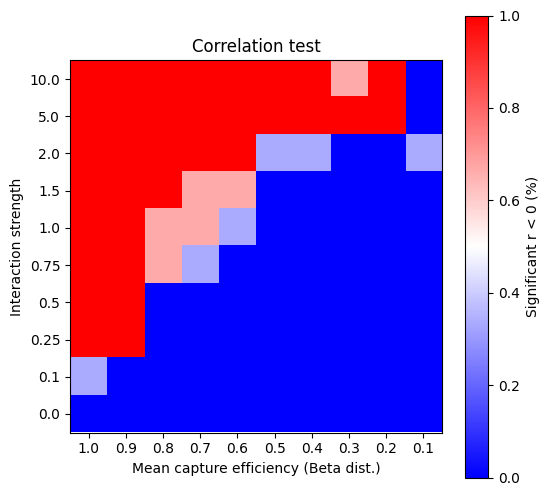

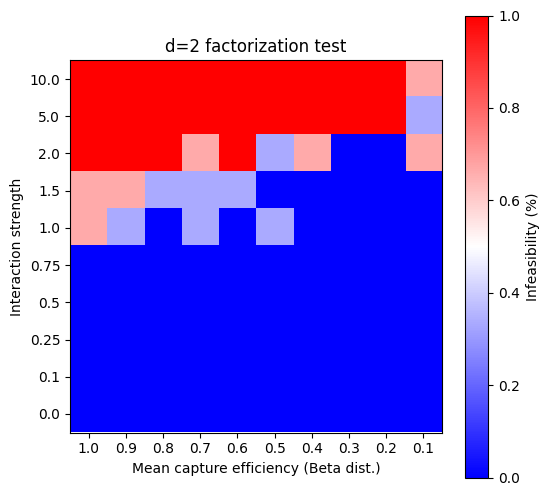

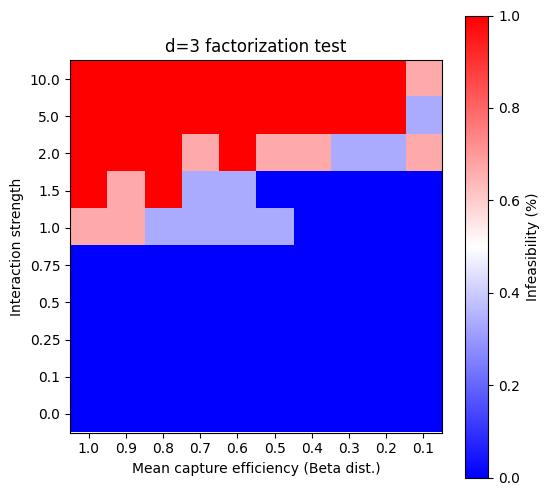

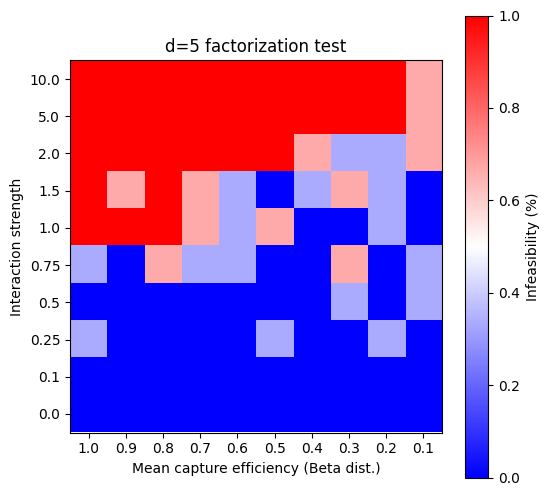

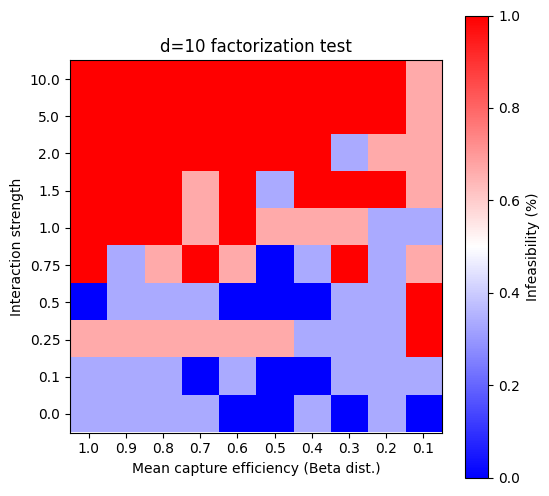

In [36]:
plot(result_corr, "Correlation test", interaction_values, capture_values, label="Significant r < 0 (%)")
plot(result_2, "d=2 factorization test", interaction_values, capture_values)
plot(result_3, "d=3 factorization test", interaction_values, capture_values)
plot(result_5, "d=5 factorization test", interaction_values, capture_values)
plot(result_10, "d=10 factorization test", interaction_values, capture_values)

## SDP

In [37]:
# settings
interaction_values = [10.0, 5.0, 2.0, 1.5, 1.0, 0.75, 0.5, 0.25, 0.1, 0.0]
capture_values = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
runs = 3
rate = 1
n = 1000

# result arrays
shape = (len(interaction_values), len(capture_values))
result_MM_2 = np.zeros(shape)
result_MM_3 = np.zeros(shape)
result_MM_5 = np.zeros(shape)
result_MM_10 = np.zeros(shape)
result_corr = np.zeros(shape)

# constraints
constraints_MM = Constraint(
    moment_bounds=True,
    moment_matrices=True,
    factorization=True
)

# count
c = 0
total = runs * len(capture_values)

# running
for i in range(runs):
    
    # simulate interaction range
    data = simulation.simulate_dataset_range_BD(interaction_values, cells=n, rate=rate)

    # downsample
    for k, m in enumerate(capture_values):

        st = time.time()

        # capture mean -> b
        b = (1 / m) - 1

        # capture
        if b == 0:
            beta = np.ones(n)
        else:
            beta = rng.beta(1, b, size=n)

        # downsample
        downsampled = data.downsample(beta)

        # bootstrap
        downsampled.bootstrap(d = 10)

        # d = 2
        d = 2
        opt_MM_2 = optimization.ModelFreeOptimization(downsampled, d, constraints=constraints_MM, printing=False, tqdm_disable=True)
        opt_MM_2.analyse_dataset()
        for j, solution in opt_MM_2.result_dict.items():
            if solution['status'] == "INFEASIBLE":
                result_MM_2[j, k] += 1 / runs

        # d = 3
        d = 3
        opt_MM_3 = optimization.ModelFreeOptimization(downsampled, d, constraints=constraints_MM, printing=False, tqdm_disable=True)
        opt_MM_3.analyse_dataset()
        for j, solution in opt_MM_3.result_dict.items():
            if solution['status'] == "INFEASIBLE":
                result_MM_3[j, k] += 1 / runs

        # d = 5
        d = 5
        opt_MM_5 = optimization.ModelFreeOptimization(downsampled, d, constraints=constraints_MM, printing=False, tqdm_disable=True)
        opt_MM_5.analyse_dataset()
        for j, solution in opt_MM_5.result_dict.items():
            if solution['status'] == "INFEASIBLE":
                result_MM_5[j, k] += 1 / runs

        # d = 10
        d = 10
        opt_MM_10 = optimization.ModelFreeOptimization(downsampled, d, constraints=constraints_MM, printing=False, tqdm_disable=True)
        opt_MM_10.analyse_dataset()
        for j, solution in opt_MM_10.result_dict.items():
            if solution['status'] == "INFEASIBLE":
                result_MM_10[j, k] += 1 / runs

        # correlation
        corr = correlation.Correlation(downsampled, printing=False, tqdm_disable=True)
        for j, solution in corr.result_dict.items():
            if solution['pvalue'] < 0.05:
                result_corr[j, k] += 1 / runs

        print(f"{c} / {total}: {time.time() - st}")
        c += 1

0 / 30: 12.053486585617065
1 / 30: 12.756767511367798
2 / 30: 12.574117422103882
3 / 30: 12.16758942604065
4 / 30: 12.201036214828491
5 / 30: 12.902347564697266
6 / 30: 13.132286548614502
7 / 30: 14.399534940719604
8 / 30: 320.1509771347046
9 / 30: 20.587111473083496
10 / 30: 12.590392351150513
11 / 30: 13.968624830245972
12 / 30: 14.327804327011108
13 / 30: 13.771000623703003
14 / 30: 16.7449734210968
15 / 30: 13.869084596633911
16 / 30: 15.647535562515259
17 / 30: 15.616978645324707
18 / 30: 18.866419076919556
19 / 30: 38.73876881599426
20 / 30: 13.350268363952637
21 / 30: 38.41633915901184
22 / 30: 15.333736658096313
23 / 30: 16.783443450927734
24 / 30: 15.105168104171753
25 / 30: 15.26162838935852
26 / 30: 20.24840760231018
27 / 30: 24.68425965309143
28 / 30: 165.9535264968872
29 / 30: 21.432921886444092


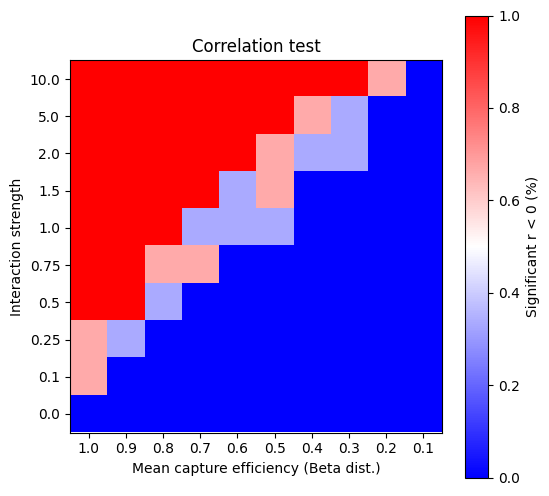

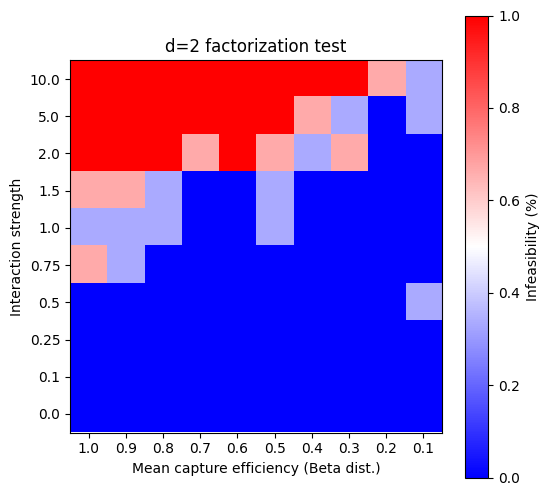

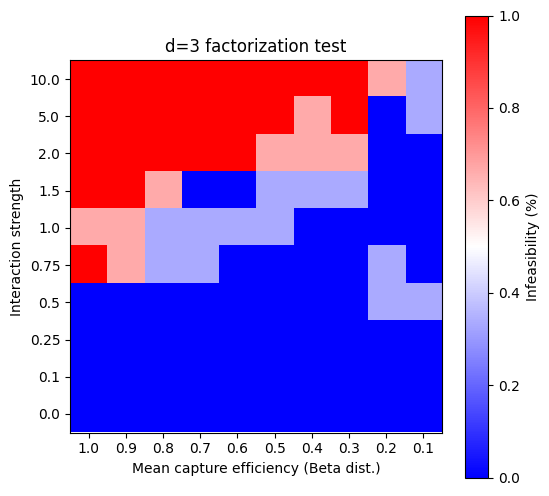

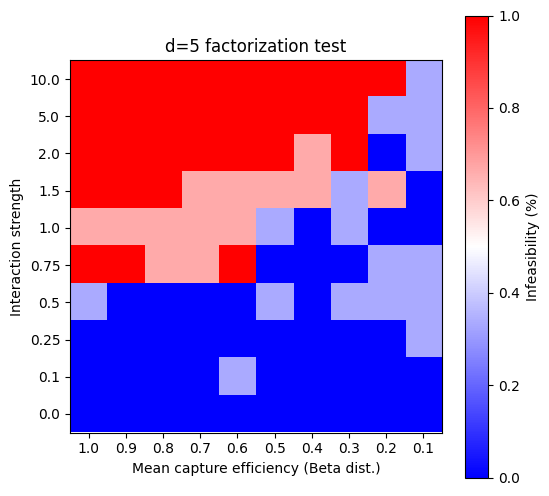

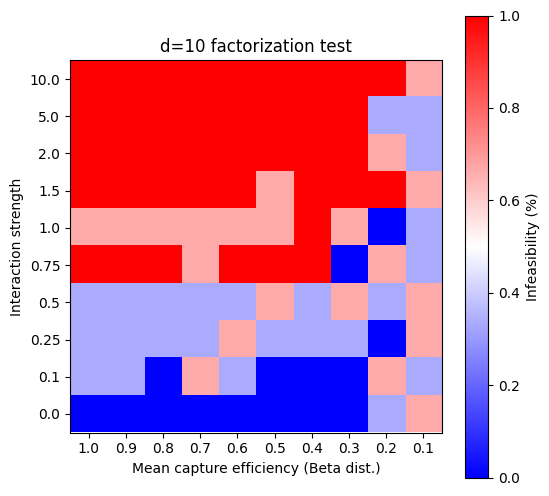

In [38]:
plot(result_corr, "Correlation test", interaction_values, capture_values, label="Significant r < 0 (%)")
plot(result_MM_2, "d=2 factorization test", interaction_values, capture_values)
plot(result_MM_3, "d=3 factorization test", interaction_values, capture_values)
plot(result_MM_5, "d=5 factorization test", interaction_values, capture_values)
plot(result_MM_10, "d=10 factorization test", interaction_values, capture_values)

# Large d

For large values e.g. $d = 30$ (but also sometimes values as small as $15$) false positives can occur and lead to independent data being infeasible (see an example above).

Even if there are not false positives, the optimization time begins to increase significantly past $d = 15$ or so.

While the minimum interaction strength detected continues to decrease, this has diminishing returns, and it is risky to use large values, especially when considering moving to real data (which will be much more messy, etc).

In [ ]:
# settings
interaction_values = [10.0, 5.0, 2.0, 1.5, 1.0, 0.75, 0.5, 0.25, 0.1, 0.0]
d_values = range(2, 20)
b = 1
runs = 3
rate = 1
n = 1000

# constraints
constraints = Constraint(
    moment_bounds=True,
    moment_matrices=False,
    factorization=True
)

# sample beta
if b == 0:
    beta = np.ones(n)
else:
    beta = rng.beta(1, b, size=n)

# result arrays
results = np.zeros((runs, len(d_values)))
times = np.zeros((runs, len(d_values), len(interaction_values)))

# for each run
for i in tqdm.tqdm(range(runs)):

    # simulate dataset with range of interaction
    data = simulation.simulate_dataset_range_BD(interaction_values, cells=n, rate=rate, tqdm_disable=False)

    # downsample
    data = data.downsample(beta)

    # bootstrap (up to highest order used)
    data.bootstrap(d_values[-1])

    # for each d
    for j, d in enumerate(d_values):

        # test feasibility (no moment matrices)
        opt = optimization.ModelFreeOptimization(data, d, constraints=constraints, printing=False, tqdm_disable=True)
        opt.analyse_dataset()

        # record time & smallest interaction strength detected
        results[i, j] = np.inf
        for k, solution in opt.result_dict.items():
            times[i, j, k] = solution['time']
            if solution['status'] == "INFEASIBLE":
                k_reg = interaction_values[k]
                prev = results[i, j]
                if k_reg < prev:
                    results[i, j] = k_reg

In [ ]:
# plot results
plt.plot(d_values, results.mean(axis=0), color="blue")
plt.scatter(d_values, results.mean(axis=0), label="(NLP) No moment matrices", color="blue")
plt.xlabel("Maximum moment order d")
plt.ylabel("Minimum interaction strength detected")
plt.title("Effect of large moment order on (in)dependence test")
plt.legend()

In [ ]:
# plot results
plt.plot(d_values, times.mean(axis=(0, 2)), color="blue")
plt.scatter(d_values, times.mean(axis=(0, 2)), label="(NLP) No moment matrices", color="blue")
plt.xlabel("Maximum moment order d")
plt.ylabel("Optimization time")
plt.title("Effect of large moment order on (in)dependence test")
plt.legend()